In [20]:
import os
import pandas as pd
import numpy as np
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
import torch
import json
import torch.nn as nn
import matplotlib.pyplot as plt
from rich import print as rprint

from trading.src.user_cache.user_cache import UserCache as user_cache
user = user_cache.load()

In [ ]:

# ---- PARAMETERS ----
ALPACA_API_KEY = user.alpaca_api_key.get_secret_value()
ALPACA_SECRET_KEY = user.alpaca_api_secret.get_secret_value()
TICKERS = ["AAPL"]  # or use ["AAPL", "MSFT", ...] for all tickers
START_DATE = "2000-01-01"
END_DATE = "2023-01-01"
CACHE_FILE = "alpaca_cache.parquet"
EPOCHS = 100
BATCH_SIZE = 16
OVERFITTING_PARAM = 0.05  # e.g., weight decay
SAVE_PARAMS = False
PARAMS_FILE = "run_params.json"
LEARNING_RATE = 2e-5
HOLD_THRESHOLD=0.01

In [22]:

# ---- DATA COLLECTION & CACHING ----
def fetch_and_cache_data(tickers, start, end, cache_file):
    if os.path.exists(cache_file):
        rprint("Loading data from cache...")
        df = pd.read_parquet(cache_file)
    else:
        rprint("Fetching data from Alpaca...")
        client = StockHistoricalDataClient(ALPACA_API_KEY, ALPACA_SECRET_KEY)
        all_data = []
        for ticker in tickers:
            request_params = StockBarsRequest(
                symbol_or_symbols=ticker,
                timeframe=TimeFrame.Day,
                start=pd.to_datetime(start),
                end=pd.to_datetime(end)
            )
            bars = client.get_stock_bars(request_params).df
            bars['ticker'] = ticker
            all_data.append(bars)
        df = pd.concat(all_data)
        df.to_parquet(cache_file)
    return df

df = fetch_and_cache_data(TICKERS, START_DATE, END_DATE, CACHE_FILE)
rprint(df.head())


Loading data from cache...

open     high     low   close      volume  \
symbol timestamp                                                                
AAPL   2016-01-04 05:00:00+00:00  102.61  105.368  102.00  105.35  71935339.0   
       2016-01-05 05:00:00+00:00  105.75  105.850  102.41  102.71  58690536.0   
       2016-01-06 05:00:00+00:00  100.56  102.370   99.87  100.70  71079827.0   
       2016-01-07 05:00:00+00:00   98.68  100.130   96.43   96.45  85996453.0   
       2016-01-08 05:00:00+00:00   98.55   99.110   96.76   96.96  75066292.0   

                                  trade_count        vwap ticker  
symbol timestamp                                                  
AAPL   2016-01-04 05:00:00+00:00     351452.0  104.007250   AAPL  
       2016-01-05 05:00:00+00:00     321365.0  103.414304   AAPL  
       2016-01-06 05:00:00+00:00     409164.0  100.847762   AAPL  
       2016-01-07 05:00:00+00:00     462836.0   98.046209   AAPL  
       2016-01-08 05:00:00+00:00     419555.0   97.916490   AAPL

In [23]:

# ---- FEATURE ENGINEERING ----
def add_features(df):
    df = df.copy()
    df['return'] = df['close'].pct_change()
    df['ma5'] = df['close'].rolling(window=5).mean()
    df['ma10'] = df['close'].rolling(window=10).mean()
    df['volatility'] = df['close'].rolling(window=5).std()
    df['target'] = (df['close'].shift(-1) > df['close']).astype(int)  # 1 if next day up, else 0
    df = df.dropna()
    return df

# 0 = SELL, 1 = HOLD, 2 = BUY
def add_trading_signals(df, hold_threshold=0.002):
    df = df.copy()
    df['future_return'] = df['close'].shift(-1) / df['close'] - 1
    # BUY if next day's return > hold_threshold, SELL if < -hold_threshold, else HOLD
    df['signal'] = np.where(df['future_return'] > hold_threshold, 2, 
                    np.where(df['future_return'] < -hold_threshold, 0, 1))
    df = df.dropna()
    return df


In [ ]:

df = add_trading_signals(df, hold_threshold=HOLD_THRESHOLD)
df = add_features(df)

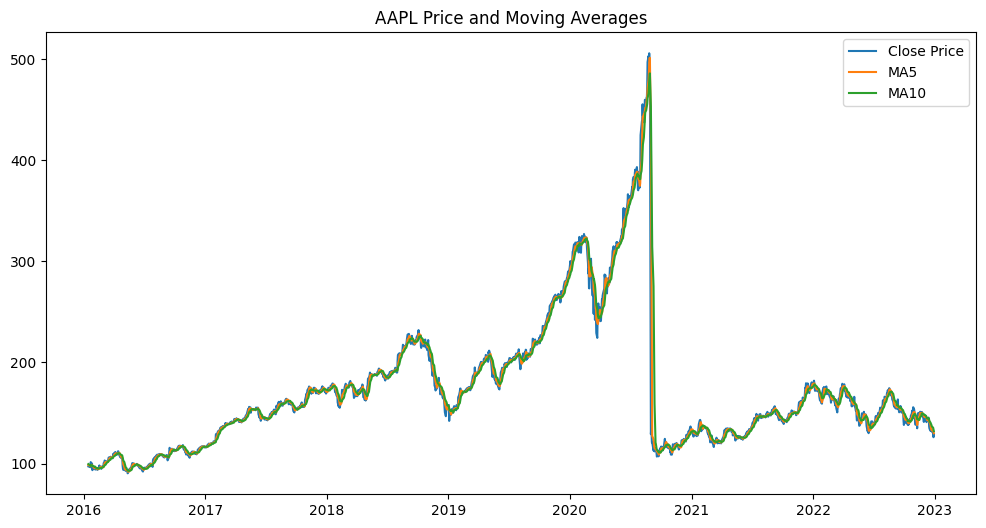

In [25]:

# ---- DATA VISUALIZATION ----
df_plot = df.reset_index()
plt.figure(figsize=(12,6))
plt.plot(df_plot['timestamp'], df_plot['close'], label='Close Price')
plt.plot(df_plot['timestamp'], df_plot['ma5'], label='MA5')
plt.plot(df_plot['timestamp'], df_plot['ma10'], label='MA10')
plt.title(f"{TICKERS[0]} Price and Moving Averages")
plt.legend()
plt.show()


In [26]:

# ---- DATA PREPARATION ----
features = ['open', 'high', 'low', 'close', 'volume', 'ma5', 'ma10', 'volatility']
X = df[features].values
y = df['signal'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)


In [27]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

In [28]:
class SimpleMLP3(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
    def forward(self, x):
        return self.net(x)

In [29]:
class ProfitLoss(torch.nn.Module):
    def __init__(self, close_prices):
        super().__init__()
        self.close_prices = torch.tensor(close_prices, dtype=torch.float32).to(device)

    def forward(self, outputs, targets, indices):
        # outputs: [batch, 3], targets: [batch], indices: [batch]
        probs = torch.softmax(outputs, dim=1)  # [batch, 3]

        batch_close = self.close_prices[indices]
        batch_next_close = self.close_prices[indices + 1]
        change = (batch_next_close - batch_close) / batch_close  # percent change

        # profit = [SELL, HOLD, BUY]
        # SELL = price drops → profit
        # BUY = price rises → profit
        # HOLD = 0
        profit_vector = torch.stack([
            -change,                     # SELL
            torch.zeros_like(change),   # HOLD
            change                      # BUY
        ], dim=1)  # [batch, 3]

        expected_profit = torch.sum(probs * profit_vector, dim=1)  # [batch]
        loss = -expected_profit.mean()  # negative to maximize expected profit
        return loss

In [30]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SimpleMLP(X_train.shape[1]).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=OVERFITTING_PARAM)
loss_fn = nn.CrossEntropyLoss()

model = SimpleMLP3(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=OVERFITTING_PARAM)
profit_loss_fn = ProfitLoss(df['close'].values)


In [31]:

# ---- TRAINING LOOP ----
def train_model(model, X_train, y_train, epochs, batch_size):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        permutation = np.random.permutation(len(X_train))
        for i in range(0, len(X_train), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x = torch.tensor(X_train[indices], dtype=torch.float32).to(device)
            batch_y = torch.tensor(y_train[indices], dtype=torch.long).to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / (len(X_train) // batch_size)
        rprint(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# profit-based loss
def train_model_profit(model, X_train, y_train, epochs, batch_size):
    model.train()
    n = len(X_train)
    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0
        permutation = np.random.permutation(n-1)  # n-1 to avoid index error with next day's price
        for i in range(0, n-batch_size, batch_size):  # ensure we have enough samples for next day's price
            batch_indices = permutation[i:i+batch_size]
            batch_x = torch.tensor(X_train[batch_indices], dtype=torch.float32).to(device)
            batch_y = torch.tensor(y_train[batch_indices], dtype=torch.long).to(device)
            batch_indices_tensor = torch.as_tensor(batch_indices, dtype=torch.long, device=device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            # Use the custom profit-based loss function
            loss = profit_loss_fn(outputs, batch_y, batch_indices_tensor)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            batch_count += 1
            
        avg_loss = total_loss / batch_count
        rprint(f"Epoch {epoch+1}/{epochs}, Profit-based Loss: {avg_loss:.6f}")

train_model_profit(model, X_train, y_train, EPOCHS, BATCH_SIZE)

# Uncomment to use standard cross-entropy training instead
# train_model(model, X_train, y_train, EPOCHS, BATCH_SIZE)


Epoch 1/100, Profit-based Loss: -0.000081

Epoch 2/100, Profit-based Loss: -0.000085

Epoch 3/100, Profit-based Loss: -0.000080

Epoch 4/100, Profit-based Loss: -0.000080

Epoch 5/100, Profit-based Loss: -0.000076

Epoch 6/100, Profit-based Loss: -0.000080

Epoch 7/100, Profit-based Loss: -0.000085

Epoch 8/100, Profit-based Loss: -0.000080

Epoch 9/100, Profit-based Loss: -0.000083

Epoch 10/100, Profit-based Loss: -0.000080

Epoch 11/100, Profit-based Loss: -0.000084

Epoch 12/100, Profit-based Loss: -0.000080

Epoch 13/100, Profit-based Loss: -0.000080

Epoch 14/100, Profit-based Loss: -0.000079

Epoch 15/100, Profit-based Loss: -0.000079

Epoch 16/100, Profit-based Loss: -0.000071

Epoch 17/100, Profit-based Loss: -0.000080

Epoch 18/100, Profit-based Loss: -0.000080

Epoch 19/100, Profit-based Loss: -0.000077

Epoch 20/100, Profit-based Loss: -0.000077

Epoch 21/100, Profit-based Loss: -0.000081

Epoch 22/100, Profit-based Loss: -0.000077

Epoch 23/100, Profit-based Loss: -0.000078

Epoch 24/100, Profit-based Loss: -0.000073

Epoch 25/100, Profit-based Loss: -0.000076

Epoch 26/100, Profit-based Loss: -0.000077

Epoch 27/100, Profit-based Loss: -0.000073

Epoch 28/100, Profit-based Loss: -0.000074

Epoch 29/100, Profit-based Loss: -0.000072

Epoch 30/100, Profit-based Loss: -0.000075

Epoch 31/100, Profit-based Loss: -0.000073

Epoch 32/100, Profit-based Loss: -0.000073

Epoch 33/100, Profit-based Loss: -0.000068

Epoch 34/100, Profit-based Loss: -0.000068

Epoch 35/100, Profit-based Loss: -0.000069

Epoch 36/100, Profit-based Loss: -0.000068

Epoch 37/100, Profit-based Loss: -0.000065

Epoch 38/100, Profit-based Loss: -0.000063

Epoch 39/100, Profit-based Loss: -0.000065

Epoch 40/100, Profit-based Loss: -0.000059

Epoch 41/100, Profit-based Loss: -0.000064

Epoch 42/100, Profit-based Loss: -0.000062

Epoch 43/100, Profit-based Loss: -0.000064

Epoch 44/100, Profit-based Loss: -0.000060

Epoch 45/100, Profit-based Loss: -0.000062

Epoch 46/100, Profit-based Loss: -0.000061

Epoch 47/100, Profit-based Loss: -0.000058

Epoch 48/100, Profit-based Loss: -0.000057

Epoch 49/100, Profit-based Loss: -0.000055

Epoch 50/100, Profit-based Loss: -0.000057

Epoch 51/100, Profit-based Loss: -0.000056

Epoch 52/100, Profit-based Loss: -0.000057

Epoch 53/100, Profit-based Loss: -0.000053

Epoch 54/100, Profit-based Loss: -0.000053

Epoch 55/100, Profit-based Loss: -0.000051

Epoch 56/100, Profit-based Loss: -0.000051

Epoch 57/100, Profit-based Loss: -0.000052

Epoch 58/100, Profit-based Loss: -0.000052

Epoch 59/100, Profit-based Loss: -0.000051

Epoch 60/100, Profit-based Loss: -0.000048

Epoch 61/100, Profit-based Loss: -0.000048

Epoch 62/100, Profit-based Loss: -0.000046

Epoch 63/100, Profit-based Loss: -0.000043

Epoch 64/100, Profit-based Loss: -0.000046

Epoch 65/100, Profit-based Loss: -0.000045

Epoch 66/100, Profit-based Loss: -0.000045

Epoch 67/100, Profit-based Loss: -0.000042

Epoch 68/100, Profit-based Loss: -0.000040

Epoch 69/100, Profit-based Loss: -0.000040

Epoch 70/100, Profit-based Loss: -0.000043

Epoch 71/100, Profit-based Loss: -0.000039

Epoch 72/100, Profit-based Loss: -0.000040

Epoch 73/100, Profit-based Loss: -0.000037

Epoch 74/100, Profit-based Loss: -0.000039

Epoch 75/100, Profit-based Loss: -0.000039

Epoch 76/100, Profit-based Loss: -0.000040

Epoch 77/100, Profit-based Loss: -0.000037

Epoch 78/100, Profit-based Loss: -0.000037

Epoch 79/100, Profit-based Loss: -0.000036

Epoch 80/100, Profit-based Loss: -0.000036

Epoch 81/100, Profit-based Loss: -0.000035

Epoch 82/100, Profit-based Loss: -0.000033

Epoch 83/100, Profit-based Loss: -0.000033

Epoch 84/100, Profit-based Loss: -0.000029

Epoch 85/100, Profit-based Loss: -0.000035

Epoch 86/100, Profit-based Loss: -0.000032

Epoch 87/100, Profit-based Loss: -0.000032

Epoch 88/100, Profit-based Loss: -0.000033

Epoch 89/100, Profit-based Loss: -0.000030

Epoch 90/100, Profit-based Loss: -0.000030

Epoch 91/100, Profit-based Loss: -0.000028

Epoch 92/100, Profit-based Loss: -0.000028

Epoch 93/100, Profit-based Loss: -0.000029

Epoch 94/100, Profit-based Loss: -0.000028

Epoch 95/100, Profit-based Loss: -0.000026

Epoch 96/100, Profit-based Loss: -0.000028

Epoch 97/100, Profit-based Loss: -0.000028

Epoch 98/100, Profit-based Loss: -0.000026

Epoch 99/100, Profit-based Loss: -0.000025

Epoch 100/100, Profit-based Loss: -0.000025

In [32]:

# ---- TESTING ----
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    outputs = model(X_test_tensor)
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    acc = accuracy_score(y_test, preds)
    rprint("Test Accuracy:", acc)
    rprint(classification_report(y_test, preds))


Test Accuracy: 0.46438746438746437

/home/matthew-jacobsen/.cache/pypoetry/virtualenvs/ramblingrealms-trading-RC3nh33Z-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matthew-jacobsen/.cache/pypoetry/virtualenvs/ramblingrealms-trading-RC3nh33Z-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matthew-jacobsen/.cache/pypoetry/virtualenvs/ramblingrealms-trading-RC3nh33Z-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined

precision    recall  f1-score   support

           0       0.56      0.09      0.16       158
           1       0.00      0.00      0.00        36
           2       0.46      0.94      0.62       157

    accuracy                           0.46       351
   macro avg       0.34      0.35      0.26       351
weighted avg       0.45      0.46      0.35       351

In [33]:

# ---- PARAMETER SAVING ----
if SAVE_PARAMS:
    params = {
        "tickers": TICKERS,
        "start_date": START_DATE,
        "end_date": END_DATE,
        "features": features,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "overfitting_param": OVERFITTING_PARAM,
        "test_accuracy": acc
    }
    with open(PARAMS_FILE, "w") as f:
        json.dump(params, f, indent=2)
    rprint(f"Parameters saved to {PARAMS_FILE}")

# ---- EXTENSIONS ----
# - To use all tickers, set TICKERS to a list of all tickers.
# - Add more features/signals in add_features().
# - Tune EPOCHS, OVERFITTING_PARAM, etc.
# - Add profit simulation by trading on model predictions.